<a href="https://colab.research.google.com/github/PawinData/TM/blob/main/TM_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import namedtuple
from pickle import dump, load

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=19)  # read in training set
twenty_test  = fetch_20newsgroups(subset='test',  shuffle=True, random_state=29)  # read in test set

print("There are", len(twenty_train.filenames), "files in the training set under", len(twenty_train.target_names), "categories: \n")
for title in twenty_train.target_names:
    print(title)
print("")
print("There are", len(twenty_test.filenames), "files in the test set under", len(twenty_test.target_names), "categories.")

There are 11314 files in the training set under 20 categories: 

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc

There are 7532 files in the test set under 20 categories.


In [3]:
# organize evaluation metrics with namedtuples
Train = namedtuple("Train", ["Precision","Recall","F1"])
Test  = namedtuple("Test", ["Precision","Recall","F1"])

def evaluate(truth, predicted, which_set):
    P = precision_score(truth, predicted, average="macro")
    R = recall_score(truth, predicted, average="macro")
    F = f1_score(truth, predicted, average="macro")
    if which_set=="Train":
        return Train(P,R,F)  
    else:
         return Test(P,R,F)

In [ ]:
# visualize classifier metrics
def viz_res(DF, TITLE=None, FigSize=(12,8), MarkerSize=12, fnts=18):
    fig,ax = plt.subplots(figsize=FigSize)
    for which_set in DF.columns:
        CLR = "darkblue" if which_set=="Train" else "darkolivegreen"
        ax.plot(DF.index, [cell.Precision for cell in DF[which_set]],
                color=CLR, marker="o", markersize=MarkerSize, linewidth=0,
                label="Precision for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.Recall for cell in DF[which_set]],
                color=CLR, marker="x", markersize=MarkerSize, linewidth=0,
                label="Recall for "+str(which_set)+" Set")
        ax.plot(DF.index, [cell.F1 for cell in DF[which_set]],
                color=CLR, marker="^", markersize=MarkerSize, linewidth=0,
                label="F1 for "+str(which_set)+" Set")
    for elements in ax.lines:
        xs = elements.get_xydata()[:,0]
        jittered_xs = xs + np.random.uniform(-0.25, 0.25, xs.shape)
        elements.set_xdata(jittered_xs)
        ax.relim()
        ax.autoscale(enable=True)
    plt.xlabel("Feature", fontsize=fnts)
    plt.ylabel("Score", fontsize=fnts)
    plt.ylim(0.5,1.05)
    plt.legend(loc="upper center", fontsize=int(0.8*fnts), ncol=2, bbox_to_anchor=(0.5,1.1))
    if TITLE is not None:
        plt.savefig(TITLE+".png")
    plt.show()

# Naive Bayes Classifier

In [ ]:
NB = dict()

In [ ]:
# Train from Counts
NB_from_Counts = Pipeline([("vec_count", CountVectorizer()), ("clf", MultinomialNB())])
NB_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_Counts.predict(twenty_test.data)
# evaluate
NB["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
NB_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ('clf',MultinomialNB())])
NB_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_TF.predict(twenty_test.data)
# evaluate
NB["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
NB_from_tfIDF = Pipeline([('vec_count',CountVectorizer()), ('tfidf',TfidfTransformer()), ('clf', MultinomialNB()),])
NB_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = NB_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = NB_from_tfIDF.predict(twenty_test.data)
# evaluate
NB["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
NaiveBayes = pd.DataFrame(NB, index=["Train","Test"]).transpose()
NaiveBayes

,Train,Test
Counts,"(0.9348166390487324, 0.9228833755043991, 0.910...","(0.7621626411174734, 0.7636463041415988, 0.745..."
TF,"(0.8929939646270284, 0.819943011113042, 0.8114...","(0.7924314057319584, 0.6821951093902918, 0.672..."
tfIDF,"(0.9459403301595009, 0.9191027839411532, 0.919...","(0.8255310124210137, 0.756525006352595, 0.7557..."


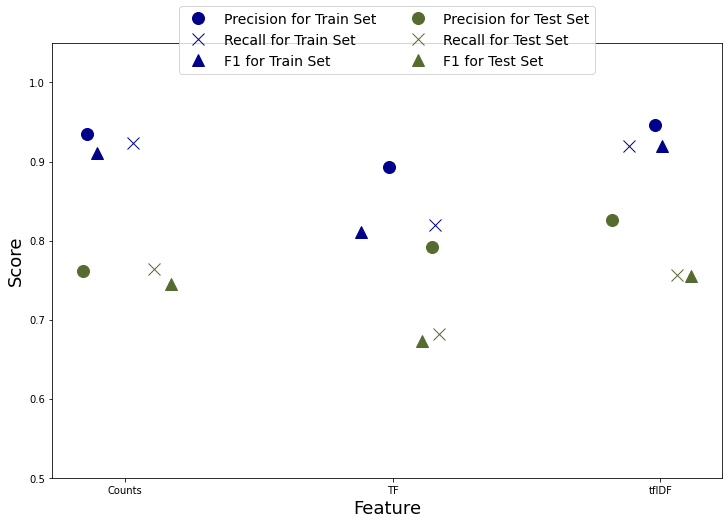

In [ ]:
viz_res(NaiveBayes, TITLE="Naive Bayes")

# Support Vector Machine Classifier

In [ ]:
SVM = dict()

In [ ]:
# Train from Counts
SVM_from_Counts = Pipeline([('vec_count', CountVectorizer()), 
                            ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=59,max_iter=5, tol=None)),
                          ])
SVM_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_Counts.predict(twenty_test.data)
# evaluate
SVM["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
SVM_from_TF = Pipeline([('vec_count', CountVectorizer()),
                        ('tf', TfidfTransformer(use_idf=False)),
                        ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=79,max_iter=5, tol=None)),
                       ])
SVM_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_TF.predict(twenty_test.data)
# evaluate
SVM["TF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
SVM_from_tfIDF = Pipeline([('vec_count', CountVectorizer()),
                           ('tfIDF', TfidfTransformer()),
                           ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=89,max_iter=5, tol=None)),
                          ])
SVM_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = SVM_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = SVM_from_tfIDF.predict(twenty_test.data)
# evaluate
SVM["tfIDF"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
SupportVectorMachine = pd.DataFrame(SVM, index=["Train","Test"]).transpose()
SupportVectorMachine

,Train,Test
Counts,"(0.9824892496018329, 0.9815918034591045, 0.981...","(0.7632170414670428, 0.7504747715611877, 0.752..."
TF,"(0.9176231701818622, 0.9055953533969816, 0.907...","(0.7789606373330445, 0.760413000061468, 0.7561..."
tfIDF,"(0.9676615733861244, 0.9619546416193036, 0.963...","(0.8267458608117908, 0.8120874662717542, 0.810..."


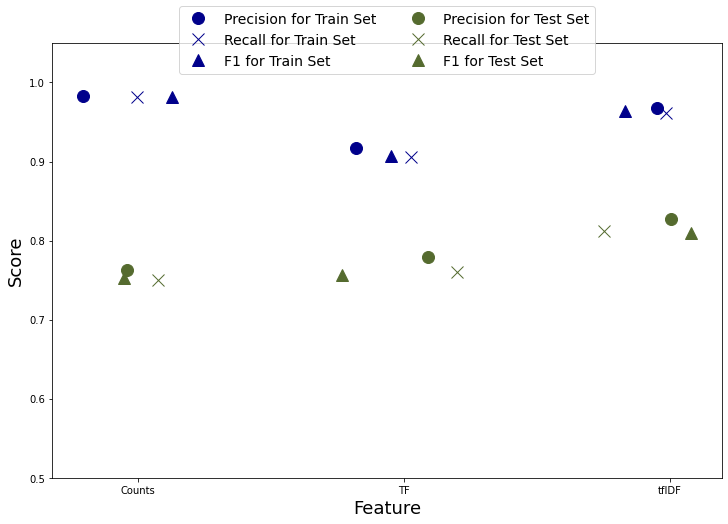

In [ ]:
viz_res(SupportVectorMachine, TITLE="Support Vector Machine")

# Decision Tree Classifier

In [ ]:
DT = dict()

In [ ]:
# Train from Counts
DT_from_Counts = Pipeline([("vec_count",CountVectorizer()), ("clf",DecisionTreeClassifier())])
DT_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_Counts.predict(twenty_test.data)
# evaluate
DT["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
DT_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ("clf",DecisionTreeClassifier())])
DT_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_TF.predict(twenty_test.data)
# evaluate
DT["TF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
DT_from_tfIDF = Pipeline([("vec_count",CountVectorizer()), ('tfIDF',TfidfTransformer()), ("clf",DecisionTreeClassifier())])
DT_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = DT_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = DT_from_tfIDF.predict(twenty_test.data)
# evaluate
DT["tfIDF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a dataframe
DecisionTree = pd.DataFrame(DT, index=["Train","Test"]).transpose()
DecisionTree

,Train,Test
Counts,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5634115799135299, 0.5618273084613687, 0.561..."
TF,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5590388429256622, 0.5532367521595069, 0.554..."
tfIDF,"(0.9999159663865547, 0.9999163879598661, 0.999...","(0.5538560375169908, 0.5499613367618847, 0.550..."


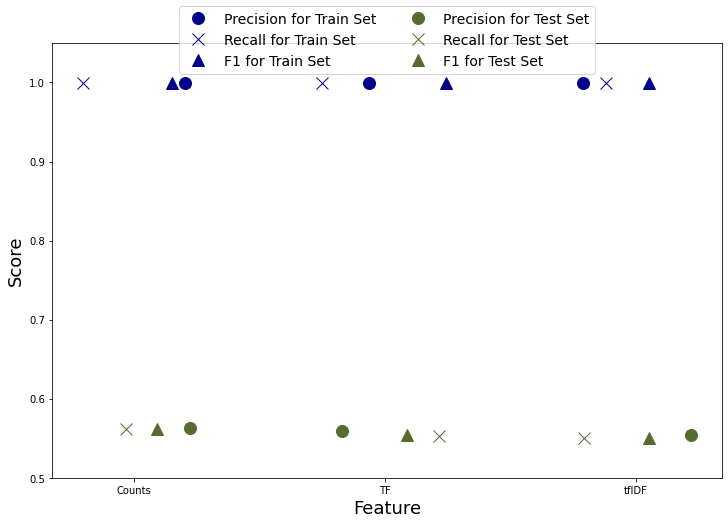

In [ ]:
viz_res(DecisionTree, TITLE="Decision Tree")

# Random Forest Classifier

In [ ]:
RF = dict()

In [ ]:
# Train from Counts
RF_from_Counts = Pipeline([("vec_count",CountVectorizer()), ("clf",RandomForestClassifier())])
RF_from_Counts.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_Counts.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_Counts.predict(twenty_test.data)
# evaluate
RF["Counts"] = [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency
RF_from_TF = Pipeline([("vec_count",CountVectorizer()), ('tf',TfidfTransformer(use_idf=False)), ("clf",RandomForestClassifier())])
RF_from_TF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_TF.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_TF.predict(twenty_test.data)
# evaluate
RF["TF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Train from Term Frequency times Inverse Document Frequency
RF_from_tfIDF = Pipeline([("vec_count",CountVectorizer()), ('tfIDF',TfidfTransformer()), ("clf",RandomForestClassifier())])
RF_from_tfIDF.fit(twenty_train.data, twenty_train.target)
# predict for training set
pred_train = RF_from_tfIDF.predict(twenty_train.data)
# predict for test set
pred_test = RF_from_tfIDF.predict(twenty_test.data)
# evaluate
RF["tfIDF"]= [evaluate(twenty_train.target, pred_train, which_set="Train"), evaluate(twenty_test.target, pred_test, which_set="Test")]

In [ ]:
# Organize results in a datafram
RandomForest = pd.DataFrame(RF, index=["Train","Test"]).transpose()
RandomForest

,Train,Test
Counts,"(0.9999165275459099, 0.9999158249158249, 0.999...","(0.7748144814873491, 0.7515762536254069, 0.750..."
TF,"(0.9999165275459099, 0.9999158249158249, 0.999...","(0.77082372552353, 0.745554870527543, 0.744200..."
tfIDF,"(0.9999165275459099, 0.9999158249158249, 0.999...","(0.769000377395874, 0.7475144124122599, 0.7453..."


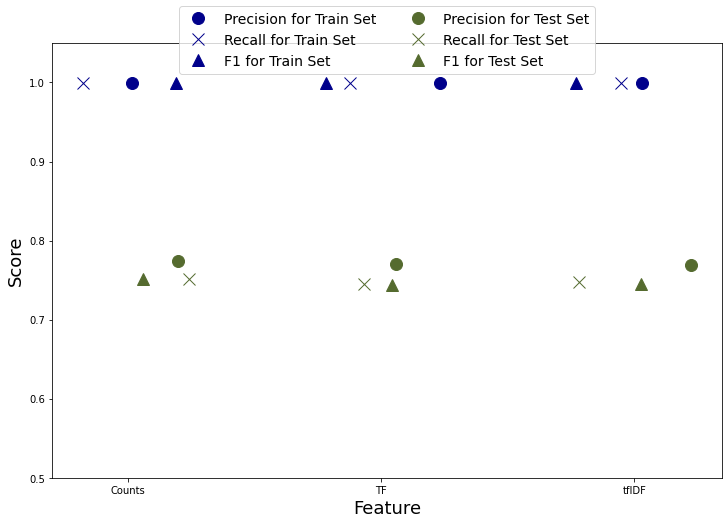

In [ ]:
viz_res(RandomForest, TITLE="Random Forest")

In [ ]:
RAW = dict()
RAW["Naive Bayes"] = NaiveBayes
RAW["SVM"] = SupportVectorMachine
RAW["Decision Tree"] = DecisionTree
RAW["Random Forest"] = RandomForest
dump(RAW, open("RawMetrics.p","wb"))

# Hyperparameters Tuning

All classifiers work sufficiently well on the training set. We will only report the performance metrics on the test set, after tuning four hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Tuned Performance of Classifiers

In [4]:
def generate(CLASSIFIER):
    lst = list()
    # predict from Occurrence
    from_Counts = Pipeline([("vec_count", CountVectorizer(stop_words='english')), ("clf", CLASSIFIER)])
    from_Counts.fit(twenty_train.data, twenty_train.target)
    pred = from_Counts.predict(twenty_test.data)
    lst.append(evaluate(twenty_test.target, pred, which_set="Test"))
    # predict from TF
    from_TF = Pipeline([("vec_count",CountVectorizer(stop_words='english')), ('tf',TfidfTransformer(use_idf=False)), ('clf',CLASSIFIER)])
    from_TF.fit(twenty_train.data, twenty_train.target)
    pred = from_TF.predict(twenty_test.data)
    lst.append(evaluate(twenty_test.target, pred, which_set="Test"))
    # predict from TF-IDF
    from_tfIDF = Pipeline([('vec_count',CountVectorizer(stop_words='english')), ('tfidf',TfidfTransformer()), ('clf', CLASSIFIER),])
    from_tfIDF.fit(twenty_train.data, twenty_train.target)
    pred = from_tfIDF.predict(twenty_test.data)
    lst.append(evaluate(twenty_test.target, pred, which_set="Test"))
    return lst

In [7]:
# row = feature, column = classifier, cell = (P,R,F)
from random import randint
DF = dict()
Classifier = ["Naive Bayes", "SVM", "Decision Tree", "Random Forest"]
Pipes = [MultinomialNB(), 
         SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, random_state=randint(100,500),max_iter=5, tol=None),
         DecisionTreeClassifier(),
         RandomForestClassifier()]
    
for CLF,PIP in zip(Classifier,Pipes):
    DF[CLF] = generate(PIP) 


,Naive Bayes,SVM,Decision Tree,Random Forest
Occurrence,"(0.8130059389269247, 0.7941583643861938, 0.778...","(0.7721601904081339, 0.7684601097154415, 0.767...","(0.5889926333277281, 0.5808592426899768, 0.582...","(0.7954908182812239, 0.7756096069291468, 0.775..."
TF,"(0.8140239067153182, 0.7724144858234616, 0.765...","(0.7925495292077662, 0.7760949486874286, 0.772...","(0.5620867937379043, 0.5590482005634667, 0.559...","(0.7887915007803081, 0.7720598095838982, 0.772..."
TF-IDF,"(0.8367634643937156, 0.8022683859017992, 0.799...","(0.8248536998550968, 0.8108138333338774, 0.809...","(0.5657523758860092, 0.5601938036424713, 0.560...","(0.7918885655472214, 0.771580896780798, 0.7711..."


In [8]:
DF = pd.DataFrame(DF, index=["Occurrence","TF","TF-IDF"])

In [82]:
def compare_viz(DF, TITLE=None, FigSize=(8,5), MarkerSize=8, fnts=14):
    CLR = ["darkorange", "darkviolet", "darkred", "dimgray"]
    pic,axs = plt.subplots(figsize=FigSize)
    for i,row in enumerate(DF.index):
        axs.plot(DF.columns, [ele.Precision for ele in DF.loc[row,]],
                 color=CLR[i], marker='o', markersize=MarkerSize, linewidth=0,
                 label="Precision by "+str(row))
        axs.plot(DF.columns, [ele.Recall for ele in DF.loc[row,]],
                 color=CLR[i], marker='x', markersize=MarkerSize, linewidth=0,
                 label="Recall by "+str(row))
        axs.plot(DF.columns, [ele.F1 for ele in DF.loc[row,]],
                 color=CLR[i], marker='^', markersize=MarkerSize, linewidth=0,
                 label="F1 by "+str(row))
    for elements in axs.lines:
        xs = elements.get_xydata()[:,0]
        jittered_xs = xs + np.random.uniform(-0.35, 0.35, xs.shape)
        elements.set_xdata(jittered_xs)
    axs.relim()
    axs.autoscale(enable=True)
    plt.xlabel("Classifier", fontsize=fnts)
    plt.ylabel("Accuracy Score", fontsize=fnts)
    plt.ylim(0.5, 1.05)
    plt.legend(loc="upper center", fontsize=int(0.8*fnts), 
               bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=True)
    if TITLE is not None:
        plt.savefig(TITLE)
    plt.show()

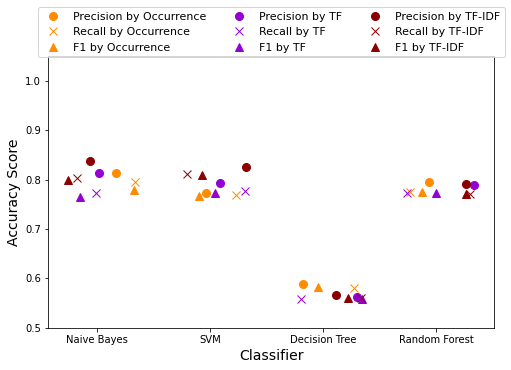

In [84]:
compare_viz(DF, TITLE="Compare.png")

In [44]:
DF.to_latex(float_format="%.2f")

'\\begin{tabular}{lllll}\n\\toprule\n{} &                                        Naive Bayes &                                                SVM &                                      Decision Tree &                                      Random Forest \\\\\n\\midrule\nOccurrence &  (0.8130059389269247, 0.7941583643861938, 0.778... &  (0.7721601904081339, 0.7684601097154415, 0.767... &  (0.5889926333277281, 0.5808592426899768, 0.582... &  (0.7954908182812239, 0.7756096069291468, 0.775... \\\\\nTF         &  (0.8140239067153182, 0.7724144858234616, 0.765... &  (0.7925495292077662, 0.7760949486874286, 0.772... &  (0.5620867937379043, 0.5590482005634667, 0.559... &  (0.7887915007803081, 0.7720598095838982, 0.772... \\\\\nTF-IDF     &  (0.8367634643937156, 0.8022683859017992, 0.799... &  (0.8248536998550968, 0.8108138333338774, 0.809... &  (0.5657523758860092, 0.5601938036424713, 0.560... &  (0.7918885655472214, 0.771580896780798, 0.7711... \\\\\n\\bottomrule\n\\end{tabular}\n'